In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/leslie_derti_apadb_features_pas_3_utr3.csv', sep='\t')

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type = 'apadb_count_pooled'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

model_names = [
    'aparent-resnet',
    'aparent',
    'deerect-apa',
    'polyapred',
]

model_scores = [
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_apadb_region.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_theano_legacy_30_31_34_pasaligned_native_scores_apadb_region.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_deerect_apa_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_polyapred_native_scores_shifted.npy'),
]

print("s.shape = " + str(model_scores[0].shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))


s.shape = (6944, 10)
m.shape = (6944, 10)
l.shape = (6944, 10)
y.shape = (6944, 10)
c.shape = (6944, 10)


In [3]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 10

m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

for model_ix in range(len(model_scores)) :
    model_scores[model_ix] = model_scores[model_ix][((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 100.) & (max_l < 40000.)), :]

m = m[((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 100.) & (max_l < 40000.)), :]
l = l[((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 100.) & (max_l < 40000.)), :]
c = c[((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 100.) & (max_l < 40000.)), ...]

y = c / np.sum(c, axis=1, keepdims=True)
y[np.isnan(y)] = 0.

print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(model_scores[0].shape))


m.shape = (6370, 10)
l.shape = (6370, 10)
c.shape = (6370, 10)
y.shape = (6370, 10)
s.shape = (6370, 10)


In [4]:

l = np.log(np.cumsum(l, axis=1) * m + 1.)
#l = np.maximum(l - 5., 0)


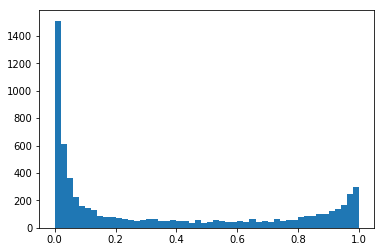

In [5]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist = np.array(y_dist)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [6]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


Evaluating model = 'aparent-resnet'
Optimization terminated successfully.
         Current function value: 0.244019
         Iterations: 56
         Function evaluations: 472
         Gradient evaluations: 59
Spearman r = 0.571
AP = 0.7
n = 6370


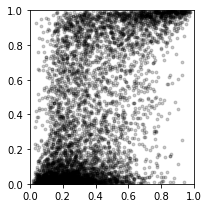

Evaluating model = 'aparent'
Optimization terminated successfully.
         Current function value: 0.267109
         Iterations: 46
         Function evaluations: 376
         Gradient evaluations: 47
Spearman r = 0.477
AP = 0.67
n = 6370


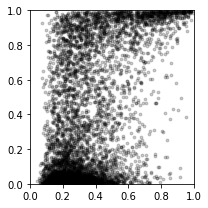

Evaluating model = 'deerect-apa'
Optimization terminated successfully.
         Current function value: 0.275624
         Iterations: 42
         Function evaluations: 368
         Gradient evaluations: 46
Spearman r = 0.492
AP = 0.63
n = 6370


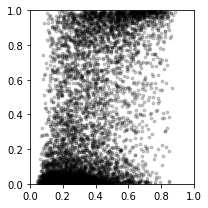

Evaluating model = 'polyapred'
Optimization terminated successfully.
         Current function value: 0.295725
         Iterations: 44
         Function evaluations: 384
         Gradient evaluations: 48
Spearman r = 0.432
AP = 0.57
n = 6370


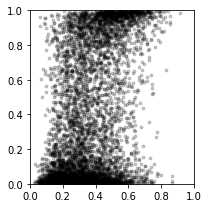

In [7]:
#Fit and evaluate regression / classification models on native measures

def logistic_model_predict(s, m, l, w_prox_pas, w_prox_len, w_prox_bias, w_dist_pas, w_dist_len, w_dist_bias, dist_mask) :
    
    prox_exp = np.exp(w_prox_pas * s + w_prox_len * l)
    dist_exp = np.exp(w_dist_pas * s + w_dist_len * l)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1) + np.exp(w_prox_bias)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1) + np.exp(w_dist_bias)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_len = w_bundle[1]
    w_prox_bias = w_bundle[2]
    w_dist_pas = w_bundle[3]
    w_dist_len = w_bundle[4]
    w_dist_bias = w_bundle[5]
    
    y_pred = logistic_model_predict(s, m, l, w_prox_pas, w_prox_len, w_prox_bias, w_dist_pas, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

model_spearman_rs = np.zeros(len(model_scores))
model_aps = np.zeros(len(model_scores))

for model_ix in range(len(model_scores)) :
    
    print("Evaluating model = '" + model_names[model_ix] + "'")
    
    s = model_scores[model_ix]
    
    w0 = np.zeros(6)

    res = minimize(logistic_model_mse, w0, args=(s, m, l, dist_mask, y_dist), method='BFGS', options={'disp': True})

    w_prox_pas = res.x[0]
    w_prox_len = res.x[1]
    w_prox_bias = res.x[2]
    w_dist_pas = res.x[3]
    w_dist_len = res.x[4]
    w_dist_bias = res.x[5]
    
    y_dist_pred = logistic_model_predict(s, m, l, w_prox_pas, w_prox_len, w_prox_bias, w_dist_pas, w_dist_len, w_dist_bias, dist_mask)
    
    spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)
    model_spearman_rs[model_ix] = spearman_r_val
    
    y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])
    
    ap = average_precision_score(y_labels, y_dist_pred)
    model_aps[model_ix] = ap

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_dist.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [8]:
#Save metrics

np.save("native_apa_multi_apadb_spearman_rs", model_spearman_rs)
np.save("native_apa_multi_apadb_aps", model_aps)


In [7]:
#Load metrics

model_spearman_rs_apadb = np.load("native_apa_multi_apadb_spearman_rs.npy")
model_aps_apadb = np.load("native_apa_multi_apadb_aps.npy")

model_spearman_rs_leslie = np.load("native_apa_multi_leslie_spearman_rs.npy")
model_aps_leslie = np.load("native_apa_multi_leslie_aps.npy")

model_spearman_rs_derti = np.load("native_apa_multi_derti_spearman_rs.npy")
model_aps_derti = np.load("native_apa_multi_derti_aps.npy")


APADB  Spearman r = [0.57, 0.48, 0.49, 0.43]
Leslie Spearman r = [0.52, 0.43, 0.47, 0.41]
Derti  Spearman r = [0.43, 0.4, 0.37, 0.34]


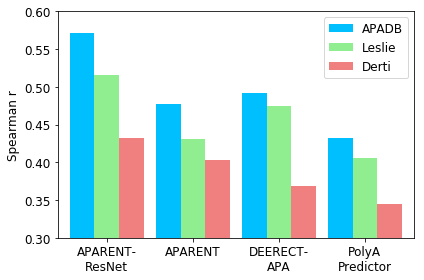

APADB  AP = [0.7, 0.67, 0.63, 0.57]
Leslie AP = [0.7, 0.68, 0.64, 0.57]
Derti  AP = [0.65, 0.64, 0.57, 0.54]


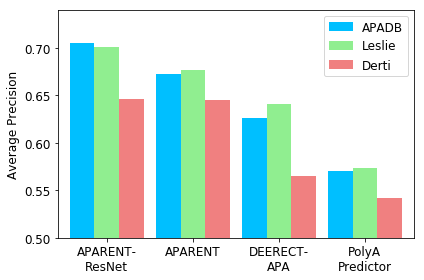

In [8]:

print("APADB  Spearman r = " + str(np.round(model_spearman_rs_apadb, 2).tolist()))
print("Leslie Spearman r = " + str(np.round(model_spearman_rs_leslie, 2).tolist()))
print("Derti  Spearman r = " + str(np.round(model_spearman_rs_derti, 2).tolist()))

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(model_spearman_rs_apadb.shape[0]) * 3.5, model_spearman_rs_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_spearman_rs_leslie.shape[0]) * 3.5 + 1, model_spearman_rs_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_spearman_rs_derti.shape[0]) * 3.5 + 2, model_spearman_rs_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 13.5)
plt.ylim(0.3)

plt.xticks([1, 4.5, 8, 11.5], ['APARENT-\nResNet', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Spearman r', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_eval_bars_spearman_r.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_eval_bars_spearman_r.eps")

plt.show()


print("APADB  AP = " + str(np.round(model_aps_apadb, 2).tolist()))
print("Leslie AP = " + str(np.round(model_aps_leslie, 2).tolist()))
print("Derti  AP = " + str(np.round(model_aps_derti, 2).tolist()))

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(model_aps_apadb.shape[0]) * 3.5, model_aps_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_aps_leslie.shape[0]) * 3.5 + 1, model_aps_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_aps_derti.shape[0]) * 3.5 + 2, model_aps_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 13.5)
plt.ylim(0.5)

plt.xticks([1, 4.5, 8, 11.5], ['APARENT-\nResNet', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Average Precision', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_eval_bars_ap.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_eval_bars_ap.eps")

plt.show()
